In [ ]:
!pip install pennylane torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import pennylane as qml
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# 1. Data Preparation

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.79MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Filter to include only digits 0 through 3
indices = [i for i, (x, y) in enumerate(mnist_data) if y in [0, 1, 2, 3]]
filtered_data = Subset(mnist_data, indices)

In [ ]:
# Split into training and testing sets
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_data = Subset(mnist_data, train_indices)
test_data = Subset(mnist_data, test_indices)

In [ ]:
# Data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# 2. Feature Extraction using a pre-trained LeNet model

class LeNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(LeNetFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)  # Output 4-dimensional features

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the feature extractor
feature_extractor = LeNetFeatureExtractor()

In [ ]:
# 3. Quantum Circuit Definition

n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

def variational_ansatz(weights, wires):
    qml.templates.StronglyEntanglingLayers(weights, wires=wires)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs=None, weights=None):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    variational_ansatz(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
class HybridQuantumClassifier(nn.Module):
    def __init__(self):
        super(HybridQuantumClassifier, self).__init__()
        self.feature_extractor = feature_extractor
        self.n_layers = 10
        self.weight_shapes = {"weights": (self.n_layers, n_qubits, 3)}

        # Corrected: Removed 'input_dim'
        self.qlayer = qml.qnn.TorchLayer(
            quantum_circuit,
            weight_shapes=self.weight_shapes
        )

        self.classifier = nn.Linear(n_qubits, 4)  # 4 output classes

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.qlayer(x)  # Ensure x has the correct shape
        x = self.classifier(x)
        return x

# Initialize the hybrid model
model = HybridQuantumClassifier()

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/10, Loss: 0.4641, Train Accuracy: 94.46%, Test Accuracy: 98.93%
Epoch 2/10, Loss: 0.0955, Train Accuracy: 99.19%, Test Accuracy: 99.21%
Epoch 3/10, Loss: 0.0467, Train Accuracy: 99.50%, Test Accuracy: 99.37%
Epoch 4/10, Loss: 0.0279, Train Accuracy: 99.66%, Test Accuracy: 99.27%
Epoch 5/10, Loss: 0.0205, Train Accuracy: 99.72%, Test Accuracy: 99.35%
Epoch 6/10, Loss: 0.0135, Train Accuracy: 99.82%, Test Accuracy: 99.23%
Epoch 7/10, Loss: 0.0118, Train Accuracy: 99.78%, Test Accuracy: 99.60%
Epoch 8/10, Loss: 0.0109, Train Accuracy: 99.81%, Test Accuracy: 99.54%
Epoch 9/10, Loss: 0.0066, Train Accuracy: 99.88%, Test Accuracy: 99.62%
Epoch 10/10, Loss: 0.0028, Train Accuracy: 99.97%, Test Accuracy: 99.72%


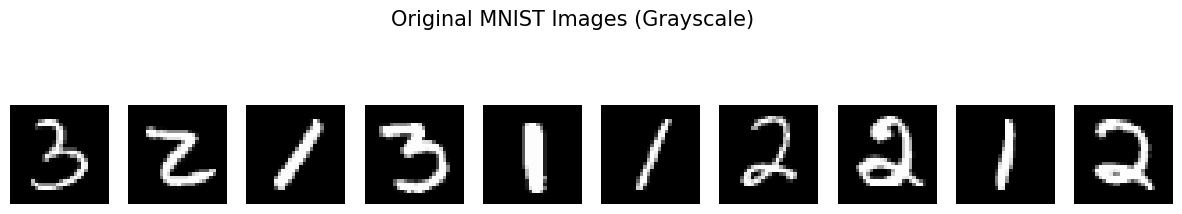

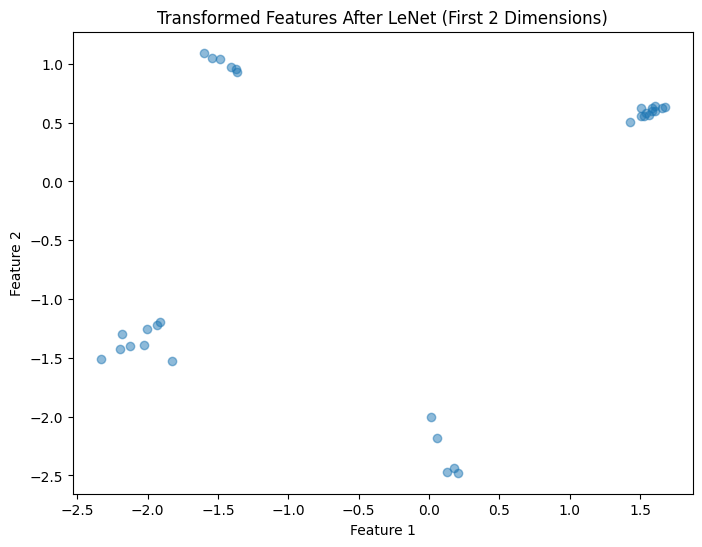

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize images
def visualize_data(loader, title, num_images=10):
    images, labels = next(iter(loader))
    images = images[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(title, fontsize=15)

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.show()

# Show original images (before scaling)
visualize_data(train_loader, title="Original MNIST Images (Grayscale)")

# Show transformed features after passing through LeNet
with torch.no_grad():
    sample_images, _ = next(iter(train_loader))
    transformed_features = feature_extractor(sample_images)
    transformed_features = transformed_features[:, :4]  # Only first 4 features for visualization

# Scatter plot of the transformed features
plt.figure(figsize=(8, 6))
plt.scatter(transformed_features[:, 0], transformed_features[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Transformed Features After LeNet (First 2 Dimensions)")
plt.show()

In [ ]:
# Print circuit diagram
print(qml.draw(quantum_circuit)(torch.randn(n_qubits), torch.randn((10, n_qubits, 3))))


0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
tensor([ 0.2273, -0.5159,  0.6644, -1.4445])
M1 = 
tensor([[[ 1.5561,  0.4550, -0.5527],
         [-0.0747,  1.4595, -1.0131],
         [ 0.0052,  0.5665, -0.1609],
         [ 0.0430, -1.0294, -0.3198]],

        [[ 0.9830,  0.5280, -0.4051],
         [ 0.5101, -1.2895,  0.0281],
         [-0.3952, -0.8952,  0.4844],
         [-0.3872, -0.1674,  0.6481]],

        [[-0.8427, -0.3823,  0.2977],
         [ 0.0850, -0.8975, -0.3030],
         [-2.1291,  0.7636, -1.3313],
         [ 0.6166,  0.2240, -0.4937]],

        [[ 0.6270,  0.3114, -0.2911],
         [-1.1489, -0.1835,  0.1450],
         [ 0.2246, -1.1827,  1.4708],
         [-0.7652,  1.1919, -0.5074]],

        [[-0.2376, -0.9551,  1.1940],
         [-0.3021,  0.8120,  0.2995],
      